*본 코드는 "What is the secret behind lotto numbers?  \\- Reflections on the fairness of the lotto and winning numbers" 에 대한 파이썬 코드 파일임.

In [2]:
#패키지 import
import pandas as pd
import numpy as np
import itertools
from scipy import stats
import matplotlib.pyplot as plt

### 2장 적합도 검정

#### 2.0.1 피어슨 카이제곱 통계량의 점근 근사이론을 이용한 검정

각 숫자 독립성 검정에서 카이제곱 통계량은
$X^2 \approx \frac{N-k}{N-1}\chi^2_{N-1}$



각 쌍 독립성 검정에서 카이제곱 통계량은
$X^2 ≈ ((k-1)\binom{N-3}{k-2}/\binom{N-2}{k-2})\chi^2_{N-1} + \binom{N-4}{k-2}/\binom{N-2}{k-2}\chi^2_{N(N-3)/2}$, in our case, N=45, k =7

In [2]:
#실제 데이터 분할표 만들기
real = pd.read_excel('korea_lottery_winners.xlsx', header = None)
real = real.iloc[:,:6]
# 각 숫자에 대한 분할표
freqtable1 = pd.Series(real.values.flatten()).value_counts().sort_index()

# 두 숫자의 쌍에 대한 분할표
numbers = list(range(1,46))
combinations = list(itertools.combinations(numbers, 2))

temp = []
for pair in combinations:
  temp.append(sum(all(element in draw for element in pair) for draw in real.values))

freqtable2 = pd.DataFrame(temp, index = combinations)

In [3]:
# 분할표의 카이제곱 통계량 계산하는 함수.
def chisq(table):
      # expected 값은 table 내의 모든 값의 합을 table의 행 개수로 나눈 값
      expected = table.sum() / table.shape[0]
      # chisq 계산
      return ((table - expected) ** 2 / expected).sum()


In [4]:
# Ho에 대한 점근적 카이제곱 검정,

N = 45
k = 6

# #moment-matching 시키면(pair 검정통계량)

# 점근적 독립성 검정

w1 = (N-k)*(k-1)/(N-2)
w2 = ((N-k)*(N-k-1))/((N-2)*(N-3))
w = np.array([w1, w2])

v1 = N-1
v2 = N*(N-3)/2
v = np.array([v1,v2])


b = (((w**3)*v).sum()) / (((w**2)*v).sum())
V = ((((w**2)*v).sum())**3) / ((((w**3)*v).sum())**2)
a = (w*v).sum() - b*V


X2_1 = chisq(freqtable1)
X2_2 = chisq(freqtable2)

print("각 숫자에 대한 점근적 검정 p-value:", stats.chi2.sf(X2_1*(N-1)/(N-k), N-1))
print("각 쌍에 대한 점근적 검정 p-value:",stats.chi2.sf((X2_2 - a)/b, V))


각 숫자에 대한 점근적 검정 p-value: 0.8687567715428611
각 쌍에 대한 점근적 검정 p-value: [0.80196892]


#### 2.1 Bootstrap 검정

In [6]:
# Ho에 대한 Bootstrap 검정.

# D회차간의 랜덤한 로또번호를 generate 시키자.
#trial generate 시키는 함수
def trial(D):
    return [sorted(np.random.choice(np.arange(1, 46), size=6, replace=False)) for _ in range(D)]

#숫자 분할표 생성함수
def gen_freqtable1(data):
  flattened_data = np.concatenate(data)
  lst = pd.Series(flattened_data).value_counts().sort_index()
  return lst

#쌍 분할표 생성함수
def gen_freqtable2(data):
  combinations = list(itertools.combinations(list(range(1,46)), 2))
  # 45x45 매트릭스 생성
  frequency_matrix = np.zeros((45, 45))

  for draw in data:
      indices = np.array(draw) - 1  # 숫자 1~45를 인덱스 0~44로 조정
      for i, j in itertools.combinations(indices, 2):
          frequency_matrix[i, j] += 1
          frequency_matrix[j, i] += 1

  upper_triangular_indices = np.triu_indices_from(frequency_matrix, k=1)
  freq_1d_array = frequency_matrix[upper_triangular_indices]

  return freq_1d_array

In [7]:
# K회 생성된 로또 샘플에 대해 기존 chi-square 통계량으로 p-value를 계산하자.
# 분할표의 카이제곱 통계량 계산하는 함수.
np.random.seed(777)

D = 1131
K = 1000 # bootstrap K번 반복
def generate_chisq_values(gen_freqtable, trial_func, D, K):
    # 결과를 미리 numpy 배열로 생성해둠
    X2values = np.empty(K)
    for i in range(K):
        table = gen_freqtable(trial_func(D))
        X2values[i] = chisq(table)
    return X2values

chisq_values_single = generate_chisq_values(gen_freqtable1, trial, D, K)
chisq_values_pair = generate_chisq_values(gen_freqtable2, trial, D, K)


In [8]:
#실제 데이터의 검정통계량 값을 이용하여 계산한 p-value
print(np.mean(int(chisq(freqtable1)) <= np.array(chisq_values_single)))
print(np.mean(int(chisq(freqtable2)) <= np.array(chisq_values_pair)))

0.898
0.785


C:\Users\jmjwj\AppData\Local\Temp\ipykernel_32428\28812861.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(np.mean(int(chisq(freqtable2)) <= np.array(chisq_values_pair)))


### 3장. 복권 구매 시뮬레이션

#### 

#### 3장 Figure 4 에 해당하는 시뮬레이션

In [ ]:
import numpy as np
import random
import itertools
from math import factorial
from functools import lru_cache
from multiprocessing import Process, Queue
from tqdm import tqdm

# Set F
numbers = list(range(1,46))
combinations = list(itertools.combinations(numbers, 6))
freqgroup25 = list(itertools.combinations(list(range(1,26)), 6))
freqgroup30 = list(itertools.combinations(list(range(1,31)), 6))
freqgroup35 = list(itertools.combinations(list(range(1,36)), 6))

othersgroup25 = list(set(combinations) - set(freqgroup25))
othersgroup30 = list(set(combinations) - set(freqgroup30))
othersgroup35 = list(set(combinations) - set(freqgroup35))

group25 = [freqgroup25, othersgroup25]
group30 = [freqgroup30, othersgroup30]
group35 = [freqgroup35, othersgroup35]


#define sampling functions

def rticket(batch_size):
    return np.array([sorted(random.sample(range(1, 46), 6)) for _ in range(batch_size)])

def comb(n, k):
    return factorial(n) // (factorial(k) * factorial(n - k))

@lru_cache(None)
def comb_cached(n, k):
    return comb(n, k)


def nrticket1(c, w, size, N = 45, k = 6): 
  class_prob = [w, 1-w]
  tickets = []
  for _ in range(size):
    group = int(np.random.choice(list(range(2)), size=1, p=class_prob))
    ticket = sorted(random.sample(c[group], 1))
    tickets.append(ticket)
  return np.array(tickets)

# work : CPU 분산처리를 위한 코드입니다.
B = 100000000

batch_size = 1000000
R = batch_size // 3
NR = batch_size - R
iter = B//batch_size

w_grid = [0.25, 0.375, 0.5]

def work25(start, end):
  for d in range(start, end):
    draw = np.sort(random.sample(list(range(1,46)), 6))
    for weight in w_grid:
      results = []
      for _ in tqdm(range(iter)):
        auto = rticket(R)
        manual = nrticket1(group25 , w = weight, size=NR).ravel().reshape(NR, -1)
        result = np.sum(np.all(draw == auto, axis=1)) + np.sum(np.all(draw == manual, axis=1))
        results.append(result)
      
      print("type : 25, d : %d, weight = %f, result = %d"%(d, weight, sum(results)))
  return 

def work30(start, end):
  for d in range(start, end):
    draw = np.sort(random.sample(list(range(1,46)), 6))
    for weight in w_grid:
      results = []
      for _ in tqdm(range(iter)):
        auto = rticket(R)
        manual = nrticket1(group30 , w = weight, size=NR).ravel().reshape(NR, -1)
        result = np.sum(np.all(draw == auto, axis=1)) + np.sum(np.all(draw == manual, axis=1))
        results.append(result)
      
      print("type : 30, d : %d, weight = %f, result = %d"%(d, weight, sum(results)))
  return 

def work35(start, end):
  for d in range(start, end):
    draw = np.sort(random.sample(list(range(1,46)), 6))
    for weight in w_grid:
      results = []
      for _ in tqdm(range(iter)):
        auto = rticket(R)
        manual = nrticket1(group35 , w = weight, size=NR).ravel().reshape(NR, -1)
        result = np.sum(np.all(draw == auto, axis=1)) + np.sum(np.all(draw == manual, axis=1))
        results.append(result)
      
      print("type : 35, d : %d, weight = %f, result = %d"%(d, weight, sum(results)))
  return 

#Define Threads

if __name__ == '__main__':
  result = Queue()
  processes = []
  for i in range(25):
    p = Process(target=work25, args=(20*i, 20*(i+1)))
    processes.append(p)

  for i in range(25):
    p = Process(target=work30, args=(20*i, 20*(i+1)))
    processes.append(p)

  for i in range(25):
    p = Process(target=work35, args=(20*i, 20*(i+1)))
    processes.append(p)


  # 모든 프로세스를 시작합니다.
  for p in processes:
      p.start()

  # 모든 프로세스가 종료될 때까지 기다립니다.
  for p in processes:
      p.join()

  result.put('STOP')
  total = 0


  while True:
      tmp = result.get()
      
      
      if tmp == 'STOP':
          break
      else:
          total += tmp

#### 위의 코드를 통해 생성 후, 간단한 전처리를 거친 데이터는 winners_25.csv, winners_30.csv, winners_35.csv에 저장되어 있다.

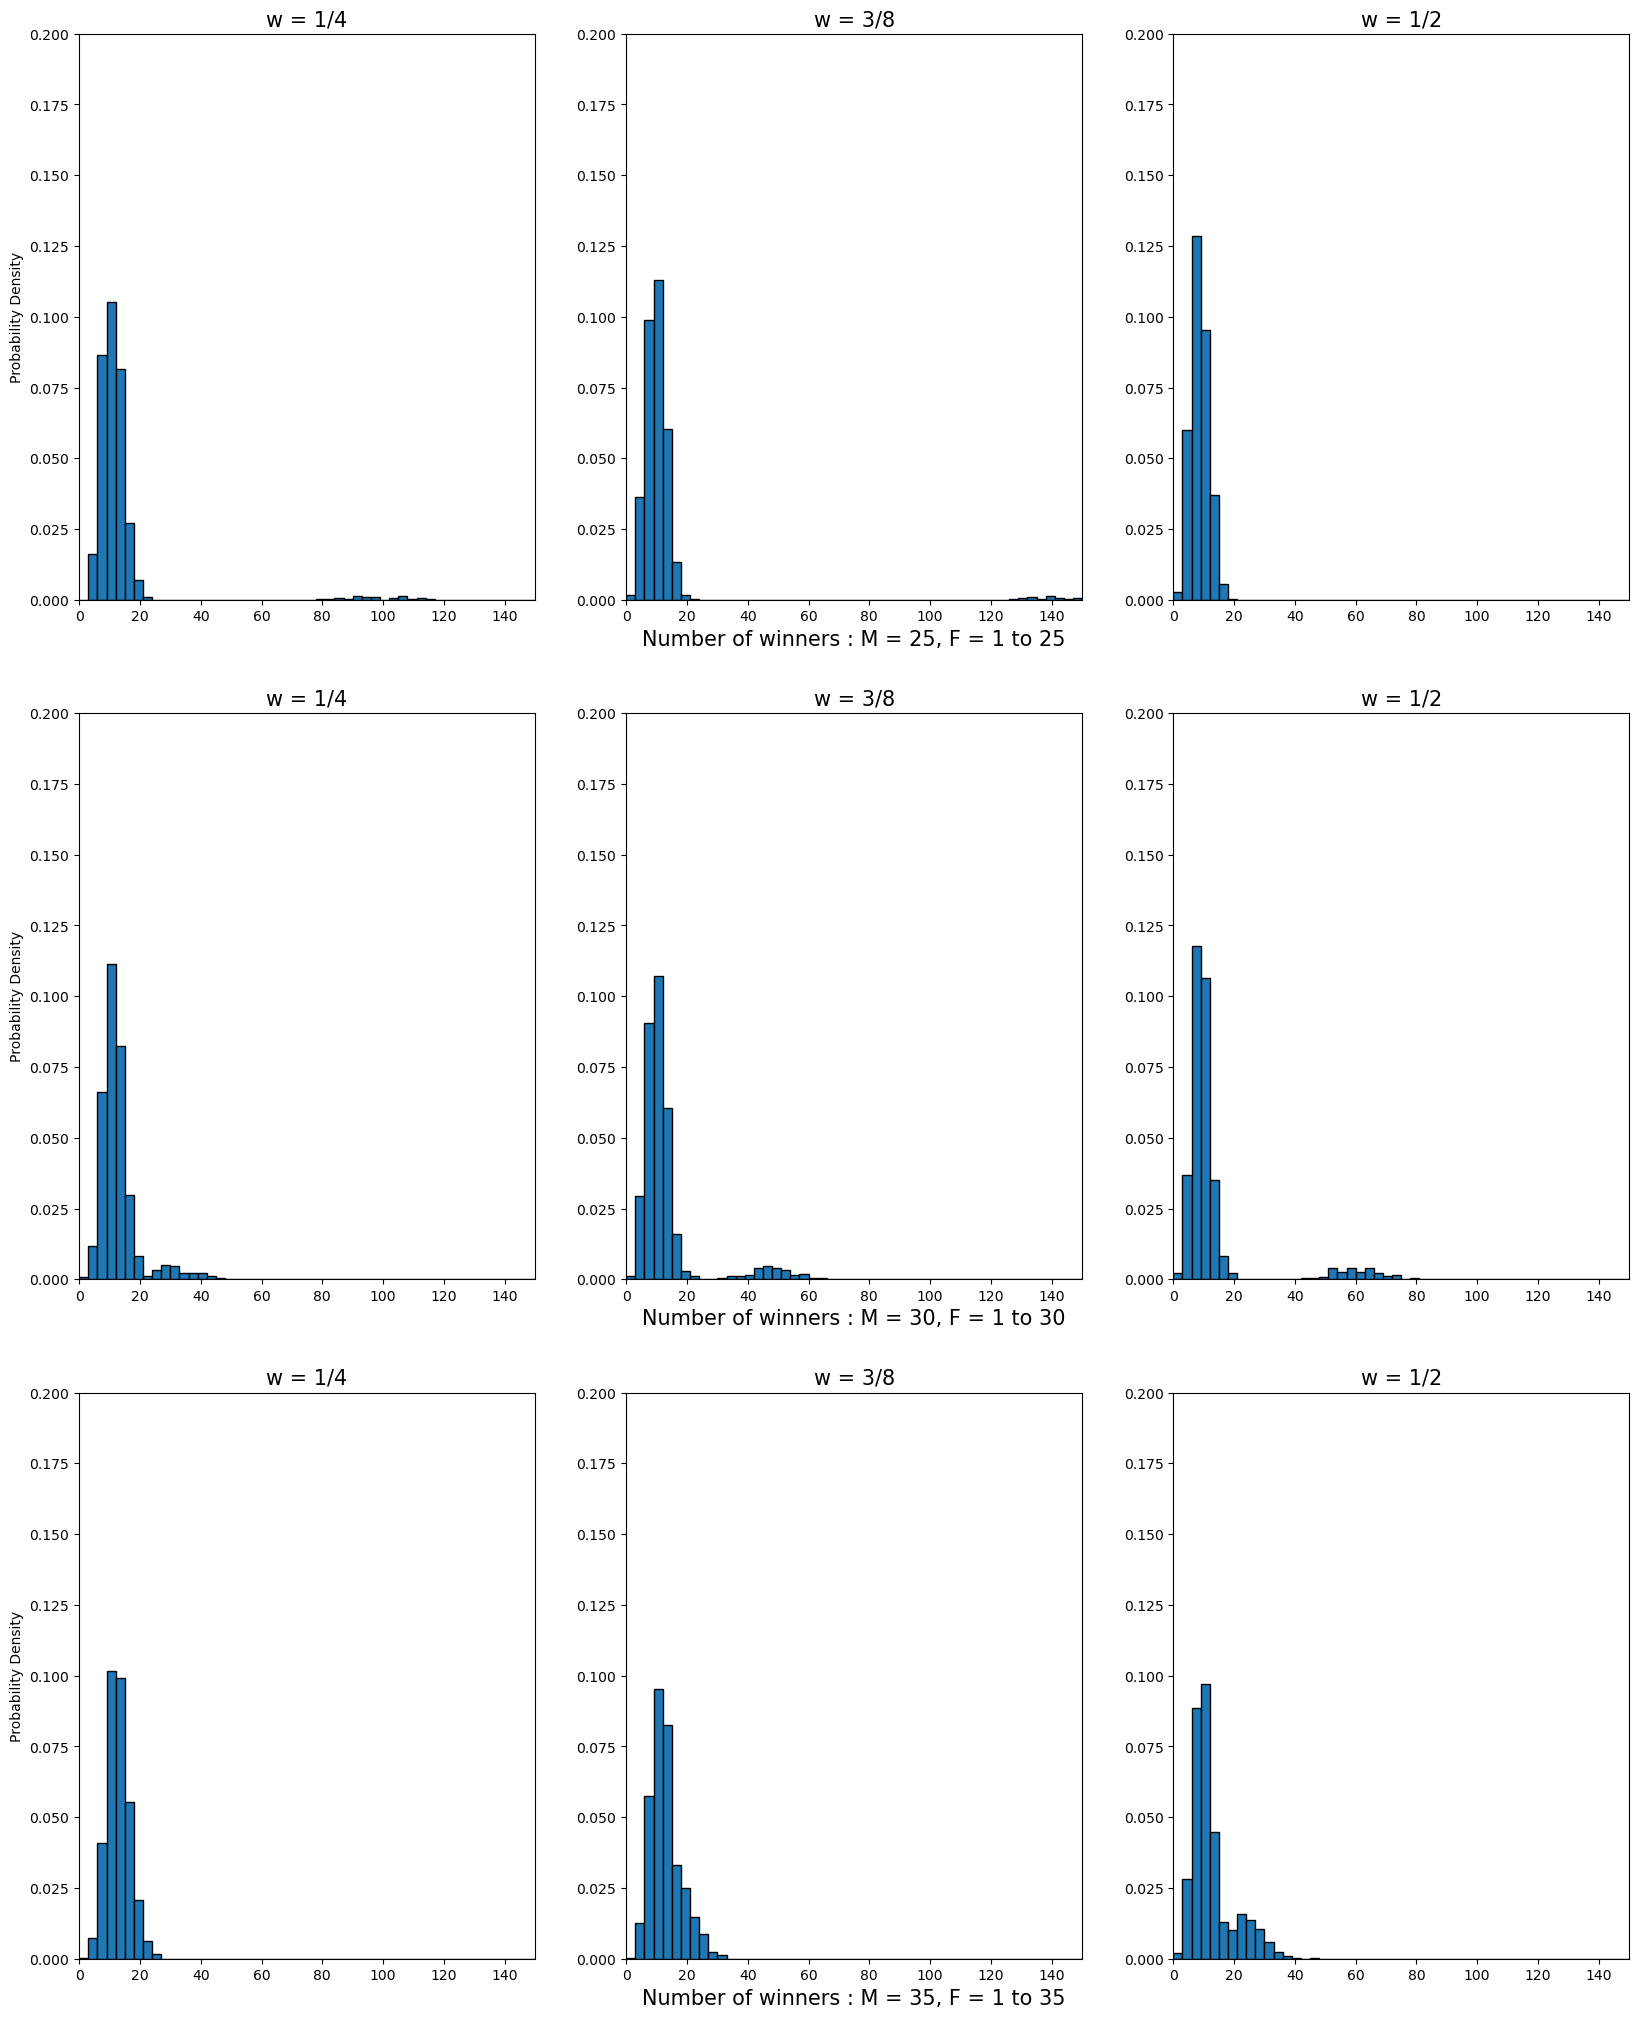

In [3]:
winners_25 = pd.read_csv('winners_25.csv').iloc[:,1:]
winners_30 = pd.read_csv('winners_30.csv').iloc[:,1:]
winners_35 = pd.read_csv('winners_35.csv').iloc[:,1:]

titles = ['1/4', '3/8', '1/2']
datas = [winners_25, winners_30, winners_35]
xlabels = ['M = 25, F = 1 to 25', 'M = 30, F = 1 to 30', 'M = 35, F = 1 to 35']
fig, ax = plt.subplots(3,3, figsize = (20,25))

bins = np.arange(0,200,3)
for k, data in enumerate(datas):
    for i, column in enumerate(data.columns):
        ax[k, i].hist(x = data[column], bins=bins, density = True, edgecolor = 'black')    
        ax[k, i].set_title(f"w = {titles[i]}", fontsize = 15)
        ax[k, 1].set_xlabel(f'Number of winners : {xlabels[k]}', fontsize = 15)
        ax[k, 0].set_ylabel('Probability Density')
        ax[k, i].set_xlim(0,150)
        ax[k, i].set_ylim(0, 0.2)

In [ ]:
for d in datas:
    print(d.mean())
    print(d.var())
    print(np.sum(d > 150))

0.25     12.613
0.375    12.391
0.5      12.096
dtype: float64
0.25     196.555787
0.375    431.489609
0.5      757.039824
dtype: float64
0.25      0
0.375     7
0.5      21
dtype: int64
0.25     12.117
0.375    12.302
0.5      12.432
dtype: float64
0.25      40.091402
0.375    109.682478
0.5      192.001377
dtype: float64
0.25     0
0.375    0
0.5      0
dtype: int64
0.25     12.236
0.375    12.409
0.5      12.017
dtype: float64
0.25     13.643948
0.375    25.038758
0.5      49.314025
dtype: float64
0.25     0
0.375    0
0.5      0
dtype: int64


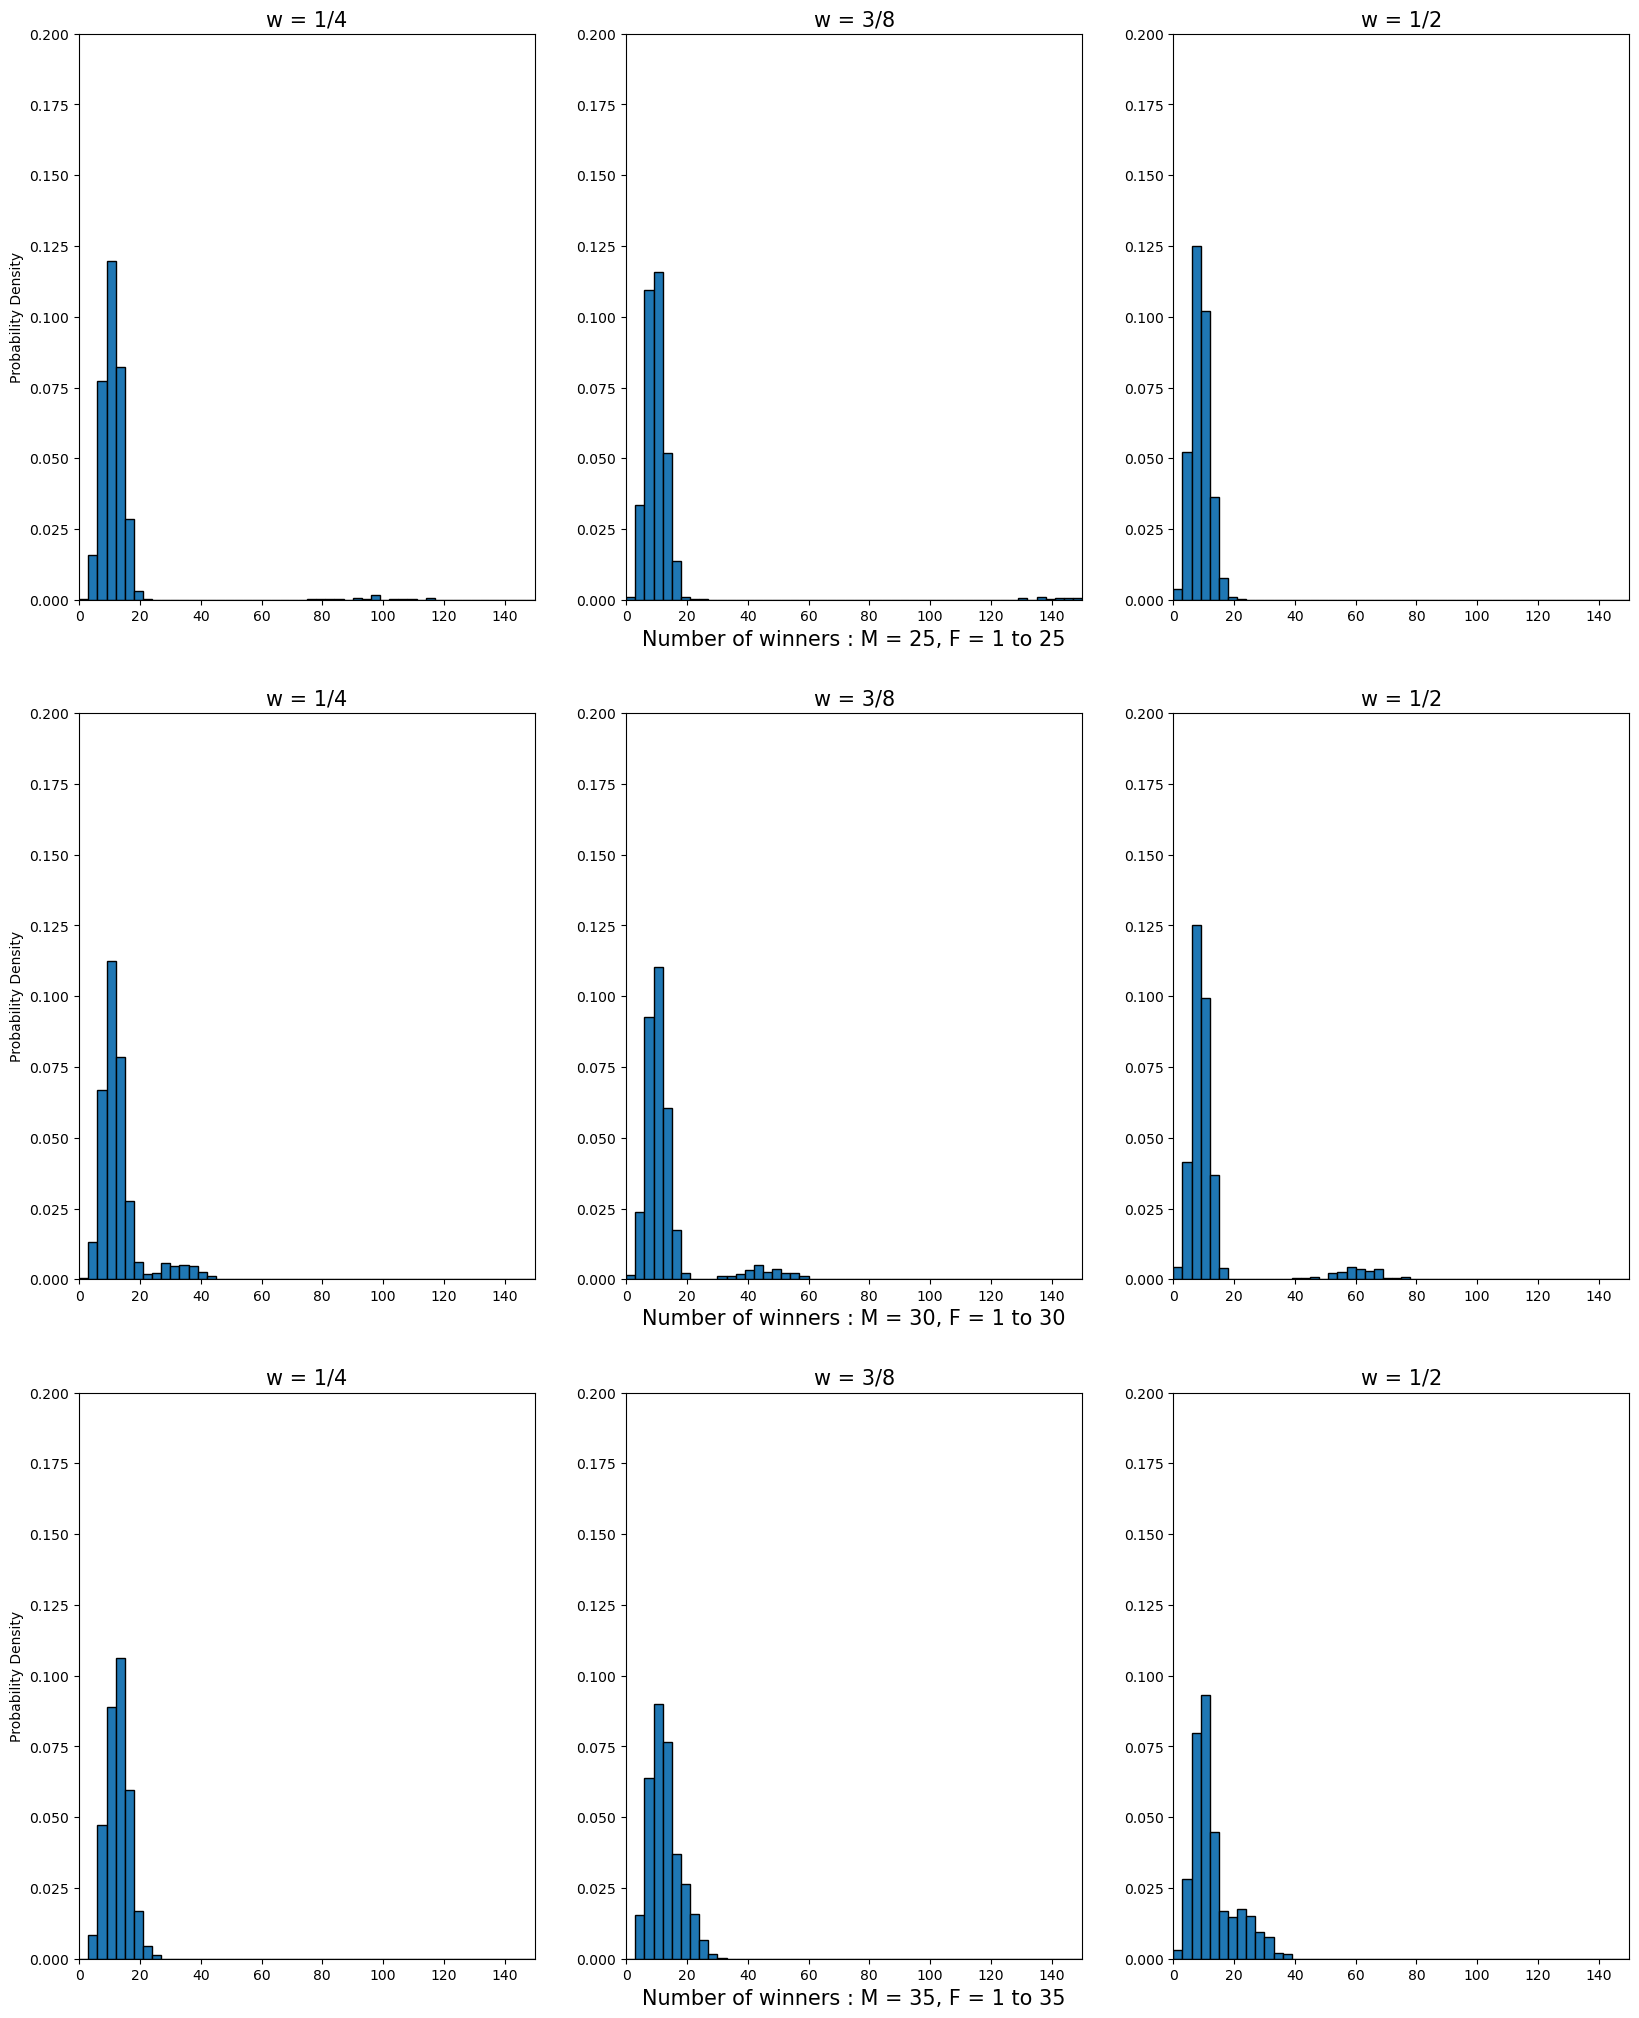

In [7]:
winners_25_diffF = pd.read_csv('winners_25_diffF.csv').iloc[:,1:]
winners_30_diffF = pd.read_csv('winners_30_diffF.csv').iloc[:,1:]
winners_35_diffF = pd.read_csv('winners_35_diffF.csv').iloc[:,1:]

titles = ['1/4', '3/8', '1/2']
datas = [winners_25_diffF, winners_30_diffF, winners_35_diffF]
xlabels = ['M = 25, F = 1 to 25', 'M = 30, F = 1 to 30', 'M = 35, F = 1 to 35']
fig, ax = plt.subplots(3,3, figsize = (20,25))

bins = np.arange(0,200,3)
for k, data in enumerate(datas):
    for i, column in enumerate(data.columns):
        ax[k, i].hist(x = data[column], bins=bins, density = True, edgecolor = 'black')    
        ax[k, i].set_title(f"w = {titles[i]}", fontsize = 15)
        ax[k, 1].set_xlabel(f'Number of winners : {xlabels[k]}', fontsize = 15)
        ax[k, 0].set_ylabel('Probability Density')
        ax[k, i].set_xlim(0,150)
        ax[k, i].set_ylim(0, 0.2)

In [8]:
for d in datas:
    print(d.mean())
    print(d.var())
    print(np.sum(d > 150))

0.25     11.836
0.375    11.761
0.5      12.381
dtype: float64
0.25     133.740845
0.375    372.434313
0.5      755.325164
dtype: float64
0.25      0
0.375     7
0.5      22
dtype: int64
0.25     12.331
0.375    12.198
0.5      11.768
dtype: float64
0.25      47.725164
0.375     97.640436
0.5      176.486663
dtype: float64
0.25     0
0.375    0
0.5      0
dtype: int64
0.25     12.133
0.375    12.249
0.5      12.387
dtype: float64
0.25     13.072383
0.375    23.802802
0.5      50.371603
dtype: float64
0.25     0
0.375    0
0.5      0
dtype: int64


#### Figure 6? 시뮬레이션


In [ ]:
import pandas as pd
import numpy as np
import random
import itertools
from math import factorial
from functools import lru_cache
from multiprocessing import Process, Queue
from tqdm import tqdm

#Define Classes
numbers = list(range(1,46))
combinations = list(itertools.combinations(numbers, 6))
freqgroup = list(itertools.combinations(list(range(1,31)), 6))
othersgroup = list(set(combinations) - set(freqgroup))
group = [freqgroup, othersgroup]


#define sampling functions
def rticket(batch_size):
    tickets = np.empty((batch_size, 6), dtype=np.int32)
    for i in range(batch_size):
        ticket = np.random.choice(np.arange(1, 46), 6, replace=False)
        tickets[i] = np.sort(ticket)
    return tickets

def nrticket1(c, w, size): 
  class_prob = [w, 1-w]
  tickets = []
  for _ in range(size):
    group = int(np.random.choice(list(range(2)), size=1, p=class_prob))
    ticket = sorted(random.sample(c[group], 1))
    tickets.append(ticket)
  return np.array(tickets)

# work
B = 100000000
batch_size = 1000000
R = batch_size // 3
NR = batch_size - R
iter = B//batch_size

w_grid_30 = [0.1, 0.2, 0.5]

def work30(start, end):
  for d in range(start, end):
    draw =  nrticket1(c = group, w = 0.3, size = 1).ravel()
    for weight in w_grid_30:
        results = []
        for _ in tqdm(range(iter)): #배치 반복 횟수.
            auto = rticket(R)
            manual = nrticket1(group, w = weight, size=NR).ravel().reshape(NR, -1)
            result = np.sum(np.all(draw == auto, axis=1)) + np.sum(np.all(draw == manual, axis=1))
            results.append(result)
        print("d : %d, weight = %f, result = %d"%(d, weight, sum(results)))
  return


if __name__ == '__main__':
  result = Queue()
  processes = []
  for i in range(75):
    p = Process(target=work30, args=(10*i, 10*(i+1)))
    processes.append(p)

  # 모든 프로세스를 시작합니다.
  for p in processes:
      p.start()

  # 모든 프로세스가 종료될 때까지 기다립니다.
  for p in processes:
      p.join()

  result.put('STOP')
  total = 0


  while True:
      tmp = result.get()
      
      
      if tmp == 'STOP':
          break
      else:
          total += tmp

In [9]:
# 시뮬레이션 시각화

# 시뮬레이션 시각화
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt

# Regular expression to capture the data
pattern = re.compile(r"group(\d+),\s*d\s*:\s*(\d+),\s*weight\s*=\s*([\d.]+),\s*result\s*=\s*(\d+)")

# Function to read a file and extract data using the regex
def extract_data_from_file(file_path):
    extracted_data = []
    
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                group_val = int(match.group(1))
                d_val = int(match.group(2))
                weight_val = float(match.group(3))
                result_val = int(match.group(4))
                
                extracted_data.append({
                    'group' : group_val,
                    'd': d_val,
                    'weight': weight_val,
                    'result': result_val
                })
    
    return pd.DataFrame(extracted_data)


In [ ]:
temp = extract_data_from_file('raw_data/result_nonrandom_draw.txt')

temp_25 = temp[temp.group == 25]
temp_30 = temp[temp.group == 30]
temp_35 = temp[temp.group == 35]


weight = [0.25, 0.375, 0.5]
data = [temp_25, temp_30, temp_35]
for df in data:
    for w in weight:
        df.loc[df.weight == w, 'd'] = list(range(1, len(df.loc[df.weight == w, 'd'])+1))

temp_25_pivoted = pd.pivot(temp_25, index = 'd', columns = 'weight', values = 'result')
temp_30_pivoted = pd.pivot(temp_30, index = 'd', columns = 'weight', values = 'result')
temp_35_pivoted = pd.pivot(temp_35, index = 'd', columns = 'weight', values = 'result')

,group,d,weight,result
0,25,1,0.25,11
1,25,2,0.25,11
2,25,3,0.25,9
3,25,4,0.25,18
4,25,5,0.25,11
...,...,...,...,...
5995,25,996,0.50,199
5996,25,997,0.50,199
5997,25,998,0.50,170
5998,25,999,0.50,175


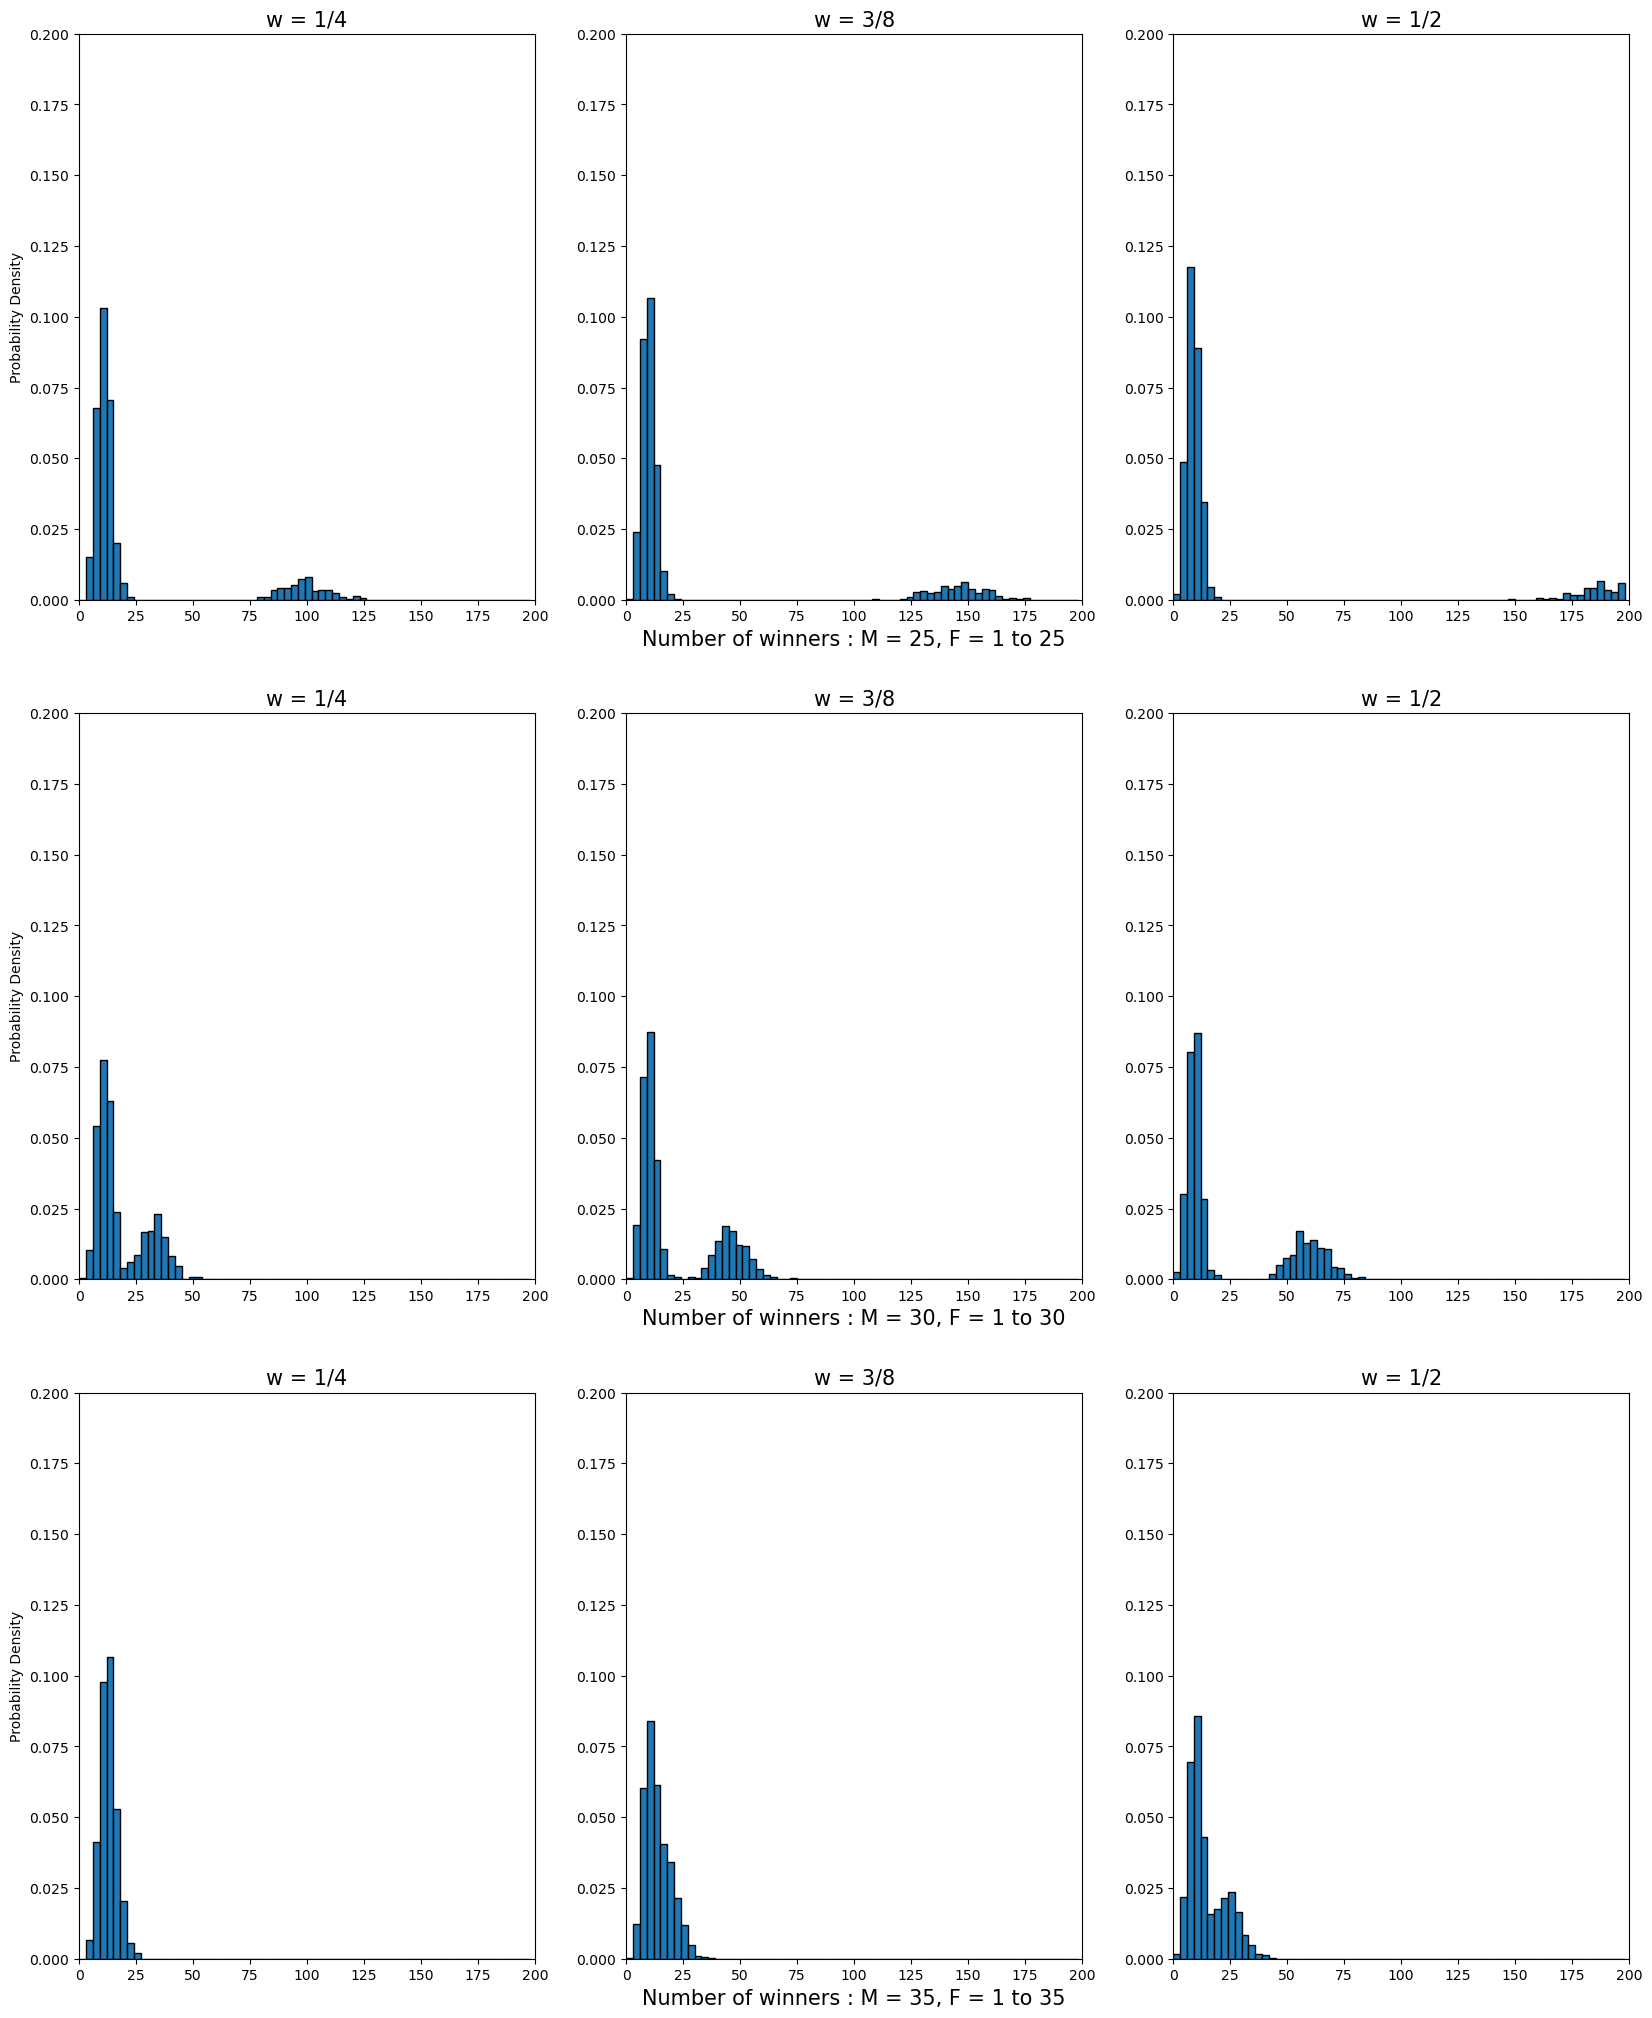

In [12]:
titles = ['1/4', '3/8', '1/2']
datas = [temp_25_pivoted, temp_30_pivoted, temp_35_pivoted]
xlabels = ['M = 25, F = 1 to 25', 'M = 30, F = 1 to 30', 'M = 35, F = 1 to 35']
fig, ax = plt.subplots(3,3, figsize = (20,25))

bins = np.arange(0,200,3)
for k, data in enumerate(datas):
    for i, column in enumerate(data.columns):
        ax[k, i].hist(x = data[column], bins=bins, density = True, edgecolor = 'black')    
        ax[k, i].set_title(f"w = {titles[i]}", fontsize = 15)
        ax[k, 1].set_xlabel(f'Number of winners : {xlabels[k]}', fontsize = 15)
        ax[k, 0].set_ylabel('Probability Density')
        ax[k, i].set_xlim(0,200)
        ax[k, i].set_ylim(0, 0.2)

### 추가코드 : Figure 3

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

winners = pd.read_excel("draw_winners.xlsx", header = None)
wins = winners.iloc[:, 1]

In [3]:

# 텍스트를 여러 줄로 분리
text = '''
2018년 39,658
2017년 37,974
2016년 35,660
2015년 32,571
2014년 30,489
2013년 29,896
2012년 28,399
2011년 27,783
2010년 24,316
2009년 23,572
2008년 22,784
2007년 22,677
2006년 24,730
2005년 27,105
2004년 32,984
2003년 38,242
'''

# 텍스트를 줄 단위로 분리
lines = text.strip().split('\n')

# 각 줄을 탭을 기준으로 분리하고 데이터프레임 생성
data = [line.split() for line in lines]
df = pd.DataFrame(data, columns=['Year', 'Value'])

# Value 컬럼에서 쉼표 제거하고 정수형으로 변환
df['Value'] = df['Value'].str.replace(',', '').astype(int)

df.head()  # 데이터프레임 확인

sold = df

In [4]:
sold.Value = (sold.Value/52)*10
sold.iloc[15,1] = sold.iloc[15,1]/2
sold.iloc[14,1] = sold.iloc[14,1]/1.5

In [5]:
newsold = pd.DataFrame({
    'Year': ['2019년','2020년','2021년','2022년','2023년'],
    'Value': [8284,9056,9836,10411,10863]
})

In [6]:
sold_weight = pd.concat([sold, newsold]).sort_values(by = 'Year').reset_index(drop = True)
sold_weight.Value = sold_weight.Value/10000

In [7]:
wins_adj = wins.reset_index()
wins_adj.columns = ['draw', 'wins']
wins_adj.draw = 1131 - wins_adj.draw
wins_adj = wins_adj.sort_values(by = 'draw').reset_index(drop = True)

In [8]:
draw_years = pd.DataFrame({
    'draw' : list(range(1,1132)),
    'Year' : ['2003년']*56 + ['2004년']*(52) + ['2005년']*(53)+
    ['2006년']*(52) + ['2007년']*52 + ['2008년']*52 + ['2009년']*52 + ['2010년']*52 +
    ['2011년']*53 + ['2012년']*52 + ['2013년']*52 + ['2014년']*52 + ['2015년']*52 + 
    ['2016년']*53 + ['2017년']*52 + ['2018년']*52 + ['2019년']*52 + ['2020년']*52 +
    ['2021년']*52 + ['2022년']*53 + ['2023년']*83
})

In [9]:
wins_weighted = pd.merge(pd.merge(wins_adj, draw_years, on = 'draw'), sold_weight, on ='Year')
wins_weighted['wins_adjusted'] = wins_weighted.wins / wins_weighted.Value

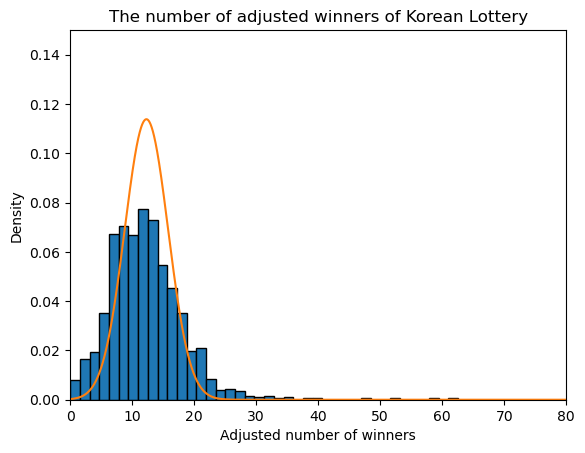

In [10]:
plt.hist(wins_weighted.wins_adjusted, bins = 40, density = True, edgecolor='black')
plt.title("The number of adjusted winners of Korean Lottery")
plt.xlabel("Adjusted number of winners")
plt.ylabel("Density")
plt.xlim(0,80)
plt.ylim(0,0.15)

x = np.linspace(0,80,8000)
normal = scipy.stats.norm.pdf(x, 12.28, np.sqrt(12.28))
plt.plot(x, normal)
#adjusted number of winners ~ Bin(100,000,000, 1/8,145,600) ~ normal(12.28, 12.28)

In [11]:
sum(wins_weighted.wins_adjusted >= 25)

31

In [12]:
np.mean(wins_weighted.wins_adjusted)

12.187968835951994

In [13]:
np.var(wins_weighted.wins_adjusted)

38.12295151102757

In [14]:
np.median(wins_weighted.wins_adjusted)

11.510791366906474